### INTRODUCTION

 - The sinking of the Titanic is one of the most famous ships in history. On April 15, 1912, the Titanic sank after colliding with an iceberg while cruising, killing 1,502 of its 2,224 passengers and crew. The exciting event shocked the international community and led to better ship safety management. 
 
 - One of the reasons why these wrecks caused so many casualties was that there were not enough lifeboats for passengers and crew. While there is some chance of surviving the sinking, some groups, such as women, children, and the upper classes, are more likely to survive than others.

### The Challenge

In this challenge, I will analyze and use ML algorithms to predict **which passengers will survive the crash**, using passenger data (ie name, age, gender, socio-economic class, etc).

In [530]:
#Import required Libraries

import pandas as pd #library for working with data
import numpy as np #library for working with numeric data
from matplotlib import pyplot as plt #library for data visualization
import seaborn as sns #library for data visualization (statistical graphs)
from scipy import stats #library for statistical functions

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#data split into train/val/test
from sklearn.model_selection import train_test_split 
#Standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler 
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

### Exploratory Data Analysis (EDA)

In [531]:
# reading train and test data into notebook
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
all_data = pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

all_data.head(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [532]:
train_data.shape

(891, 12)

In [533]:
test_data.shape

(418, 11)

In [534]:
all_data.shape

(1309, 12)

In [535]:
train_data['Pclass'].unique()     

array([3, 1, 2])

In [536]:
train_data['Sex'].unique()


array(['male', 'female'], dtype=object)

In [537]:
max_age = train_data['Age'].max()
min_age = train_data['Age'].min()

print(f'Maximum age of a passenger on the Titanic: {max_age} years')
print(f'Minimum age of a passenger on the Titanic: {min_age} years')

Maximum age of a passenger on the Titanic: 80.0 years
Minimum age of a passenger on the Titanic: 0.42 years


In [538]:
max_fare = train_data['Fare'].max()
min_fare = train_data['Fare'].min()

print(f'Maximum Passenger fare: {max_fare}')
print(f'Minimum Passenger fare: {min_fare}')

Maximum Passenger fare: 512.3292
Minimum Passenger fare: 0.0


In [539]:
train_data['Embarked'].unique()  

array(['S', 'C', 'Q', nan], dtype=object)

In [540]:
train_data.describe(include = "all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


We have a small amount of data (891 or 40% of the actual number of passengers on board the Titanic (2,224)) about passengers with eleven features (since the twelfth column "Survived" in train_data is our target variable) on train_data. And 418 on test_data.

1. `Survived` - our target variable (0 = No, 1 = Yes)
2. `PassengerId` - passenger number 
3. `Pclass` - Ticket class (1 = 1st (Upper), 2 = 2nd (Middle), 3 = 3rd (Lower))  - **categorical feature**
4. `Name` - passenger's name
5. `Sex` - passenger's sex - **binary categorical feature** (male, female)
6. `Age` - passenger's age from 0,42 to 80 years - **numeric feature (Continuous)**
7. `SibSp` - quantity of siblings/spouses aboard the Titanic - **numeric feature (Discrete)**
8. `Parch` - quantity of parents/children aboard the Titanic - **numeric feature**
9. `Ticket` - Ticket number - **alphanumeric features**
10. `Fare` - Passenger fare - **numeric feature (Continuous)**
11. `Cabin` - Cabin number - **alphanumeric features**
12. `Embarked` - Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton) - **categorical feature**

### Missing values in the data

In [541]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [542]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [543]:
all_data.isna().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

As we can see:

 - Cabin(687), Age(177), Embarked(2) features contain a number of null values for the training dataset.

 - Cabin(327), Age(86) are incomplete in case of test dataset.

This needs to be corrected.

### Age. Missing data

Text(0, 0.5, 'Age')

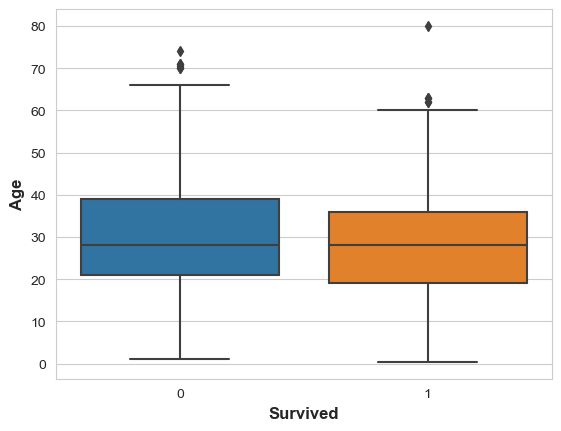

In [544]:
ax1 = sns.boxplot(x='Survived', y='Age', data=train_data)
ax1.set_xlabel('Survived', weight='bold', size=12)
ax1.set_ylabel('Age', weight='bold', size=12)

**The "Age" is an important feature** that can presumably correlate with the target variable. There is not much data, so it is important for us to understand the missing values - this is a systematic error or some random error.

For example, the 1st class passengers (or women) were not asked about their age (because it was indecent), or accidentally missed. Understanding the reason for missing values will determine how to work with these missing data.

In [545]:
# missing age or not
train_data.groupby(train_data['Age'].isnull()).mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Age,,,,,,,
False,448.582633,0.406162,2.236695,29.699118,0.512605,0.431373,34.694514
True,435.581921,0.293785,2.598870,NaN,0.564972,0.180791,22.158567


Among the passengers whose age value was missing, there were survivors (about 30%) and dead (about 70%) - column `Survived`, True = 0.29.

These passengers were in a lower class:
 - column `Pclass` - True = 2.59 (this is the average value of the class)
 - column `Fare` - True = 22.15 (this is the average value of the ticket price)
 
For a more detailed analysis, we will create a new column `Age_NaN` (binary classifier). We use the where() method, where we prescribe the condition: - if there is no value in the `Age` column, then assign the value 0 in the `Age_NaN` column, if present, then 1.

In [546]:
train_data['Age_NaN'] = np.where(train_data['Age'].isnull(), 0,1)
train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_NaN
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1


In [547]:
# missing age value depending on class
pd.crosstab(train_data['Pclass'], train_data['Age_NaN'])

Age_NaN,0,1
Pclass,,
1,30,186
2,11,173
3,136,355


In [548]:
# missing age value depending on sex
pd.crosstab(train_data['Sex'], train_data['Age_NaN'])

Age_NaN,0,1
Sex,,
female,53,261
male,124,453


**Conclusion**: among the passengers who had no age value, there were survivors (about 30%) and dead (about 70%), passengers were from different classes (there were significantly more from class 3), there were men and women among the passengers (there were significantly more men), then when interviewing survivors and when the examination of the bodies of the dead could accidentally miss the age of the passenger.

**Solution**: To replace these NaN values, we can assign them the mean age of the dataset.

But the problem is, there were many people with many different ages. We just can't assign a 4 year kid with the mean age that is 29 years. 

But we can check the Name feature. Looking upon the feature, we can see that the names have a salutation like Mr or Mrs. Thus we can assign the mean values of Mr and Mrs to the respective groups.

In [549]:
train_data['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [550]:
# extract the Salutations
all_data['Initial']=0
for i in train_data:
    all_data['Initial']=all_data.Name.str.extract('([A-Za-z]+)\.')

all_data['Initial'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: Initial, dtype: int64

There are some misspelled Initials like Miller or Me that stand for Miss. I will replace them with Miss and same thing for other values.

In [551]:
all_data['Initial'].replace(['Mlle','Mme','Ms'], 'Miss',inplace=True)
all_data['Initial'].replace(['Dr','Major','Capt','Sir','Don'], 'Mr',inplace=True)
all_data['Initial'].replace(['Lady','Countess', 'Dona'], 'Mrs',inplace=True)
all_data['Initial'].replace(['Jonkheer','Col','Rev'], 'Other',inplace=True)

all_data.groupby('Initial')['Age'].mean()

Initial
Master     5.482642
Miss      21.834533
Mr        32.545531
Mrs       37.046243
Other     44.923077
Name: Age, dtype: float64

In [552]:
all_data.loc[(all_data.Age.isnull())&(all_data.Initial=='Mr'),'Age']=33
all_data.loc[(all_data.Age.isnull())&(all_data.Initial=='Mrs'),'Age']=37
all_data.loc[(all_data.Age.isnull())&(all_data.Initial=='Master'),'Age']=5
all_data.loc[(all_data.Age.isnull())&(all_data.Initial=='Miss'),'Age']=22
all_data.loc[(all_data.Age.isnull())&(all_data.Initial=='Other'),'Age']=45

In [553]:
all_data.isna().sum()

Age               0
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
Initial           0
dtype: int64

### Cabin. Missing data

687 values in train_data and 327 values in test_data are not specified in the `Cabin` column. Since there are a lot of missing values, we can completely delete the `Cabin` column.

In [554]:
all_data.drop(['Cabin'], axis = 1, inplace = True)
all_data.head(3)

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Initial
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss


### Embarked. Missing data

Two values are not specified in the `Embarked`column. This is a categorical feature.

**Solution**: Replace the missing values by frequency. Replace the missing value with the value that is most often found in a particular column.

In [555]:
all_data['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [556]:
# replace the missing 'Embarked' values by the most frequent - S
all_data['Embarked'].replace(np.nan, 'S', inplace = True)


### Fare. Missing data

There is only one passenger with missing Fare value. We can assume that Fare is related to family size (Parch and SibSp) and Pclass features. Median Fare value of a male with a third class ticket and no family is a logical choice to fill the missing value.

In [557]:
all_data[all_data['Fare'].isnull()]

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Initial
1043,60.5,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr


In [558]:
null_fare = all_data.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
all_data['Fare'] = all_data['Fare'].fillna(null_fare)

In [559]:
all_data.isna().sum()

Age              0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
Initial          0
dtype: int64

In [560]:
def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)
    
train_data, test_data = divide_df(all_data)

In [561]:
train_data.isna().sum()

Age            0
Embarked       0
Fare           0
Name           0
Parch          0
PassengerId    0
Pclass         0
Sex            0
SibSp          0
Survived       0
Ticket         0
Initial        0
dtype: int64

In [562]:
test_data.isna().sum()

Age            0
Embarked       0
Fare           0
Name           0
Parch          0
PassengerId    0
Pclass         0
Sex            0
SibSp          0
Ticket         0
Initial        0
dtype: int64

### Analysis of features correlating with the target variable

### Sex

In [230]:
train_data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


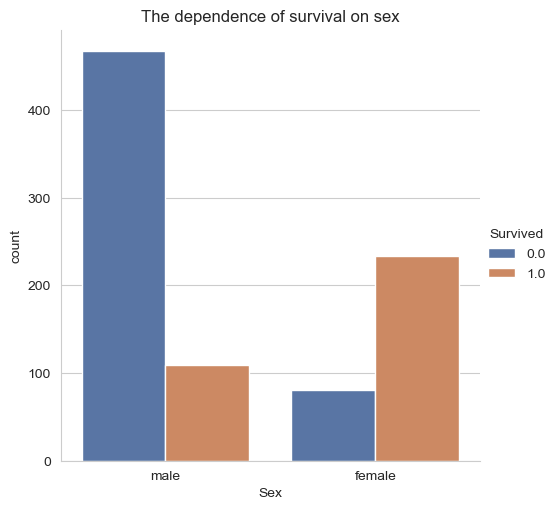

In [231]:
sns.catplot(data=train_data, x='Sex', kind='count', hue='Survived',palette='deep')
plt.title("The dependence of survival on sex")
plt.show()

**Conclusion**: Women (Sex=female) were more likely to have survived.

### Pclass

In [232]:
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


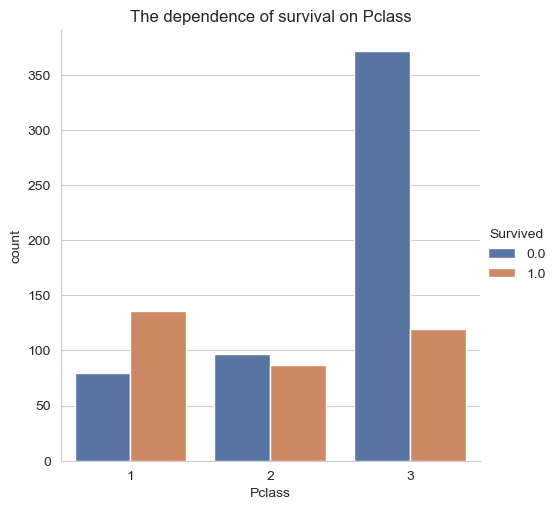

In [233]:
sns.catplot(data=train_data, x='Pclass', kind='count', hue='Survived',palette='deep')
plt.title("The dependence of survival on Pclass")
plt.show()

**Conclusion**: The upper-class passengers (Pclass=1) were more likely to have survived.

In [234]:
pd.crosstab([train_data.Sex,train_data.Survived],train_data.Pclass,margins=True).style.background_gradient(cmap='YlOrRd')


Looking at the CrossTab, we can easily infer that survival for Women from Pclass1 is about 95-96%, as only 3 out of 94 Women from Pclass1 died.

It is evident that irrespective of Pclass, Women were given first priority while rescue. Even Men from Pclass1 have a very low survival rate.

### Age

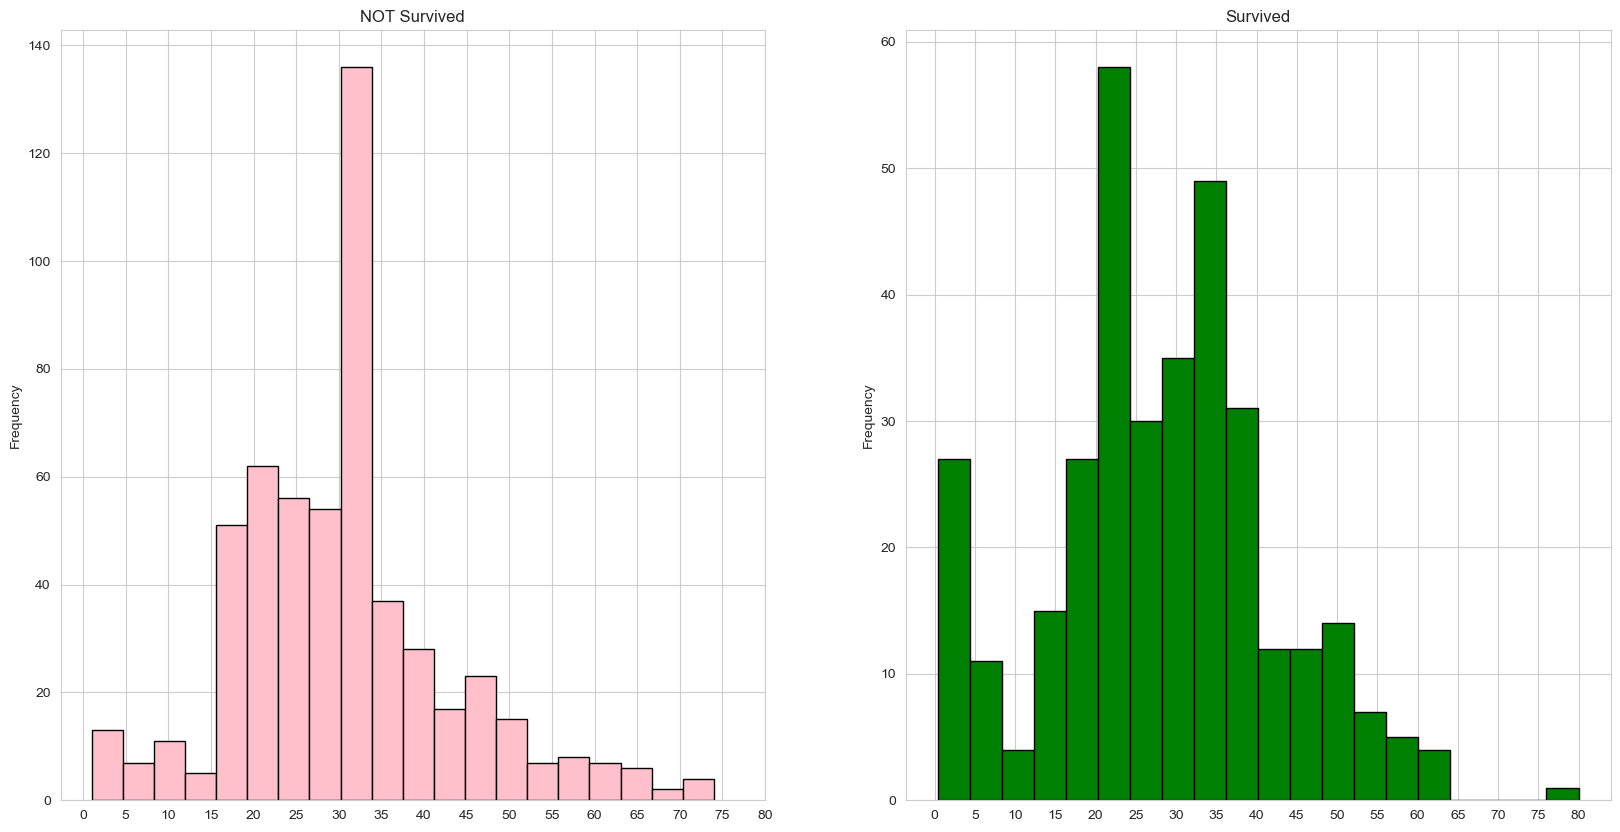

In [235]:
f,ax=plt.subplots(1,2,figsize=(20,10))

train_data[train_data['Survived']==0].Age.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='pink')
ax[0].set_title('NOT Survived')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)

train_data[train_data['Survived']==1].Age.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('Survived')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)

plt.show()

**Conclusion**:
 - The Toddlers (age<5) were saved in large numbers.
 - The oldest Passenger was saved (80 years).
 - Maximum number of deaths were in the age group of 30-35.
 - The maximum number of survivors was in the age group of 20-25 and 32-37.

### Embarked

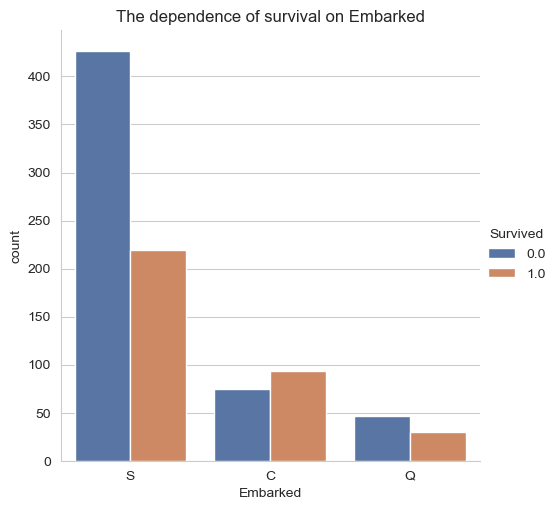

In [236]:
sns.catplot(data=train_data, x='Embarked', kind='count', hue='Survived',palette='deep')
plt.title("The dependence of survival on Embarked")
plt.show()

**Conclusion**: The chances for survival for Port C is highest around 0.55 while it is lowest for S.

### SibSp

In [237]:

pd.crosstab([train_data.SibSp], train_data.Survived).style.background_gradient(cmap='YlOrRd')


Survived,0.000000,1.000000
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


In [238]:

pd.crosstab(train_data.SibSp, train_data.Pclass).style.background_gradient(cmap='YlOrRd')


Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


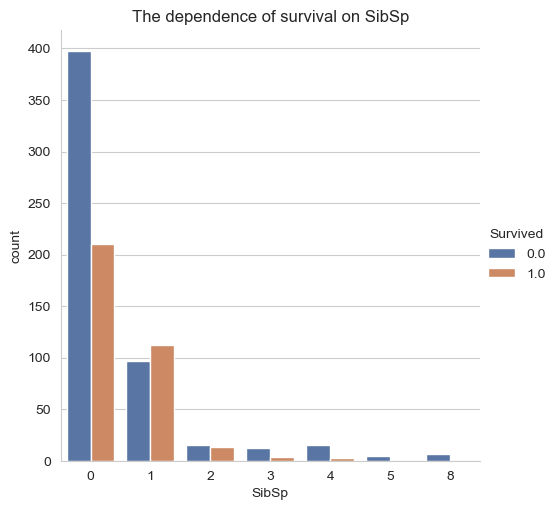

In [239]:
sns.catplot(data=train_data, x='SibSp', kind='count', hue='Survived',palette='deep')
plt.title("The dependence of survival on SibSp")
plt.show()

**Conclusion**: 
- If a passenger is on board alone, without siblings, his survival rate is the highest. Survival rate decreases if the number of siblings increases (human factor)

 - The survival rate of families of 5-8 people is 0%, since all these families belong to the 3rd class.

### Parch

In [240]:

pd.crosstab([train_data.Parch], train_data.Survived).style.background_gradient(cmap='YlOrRd')


Survived,0.000000,1.000000
Parch,,
0,445,233
1,53,65
2,40,40
3,2,3
4,4,0
5,4,1
6,1,0


In [241]:

pd.crosstab(train_data.Parch, train_data.Pclass).style.background_gradient(cmap='YlOrRd')


Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


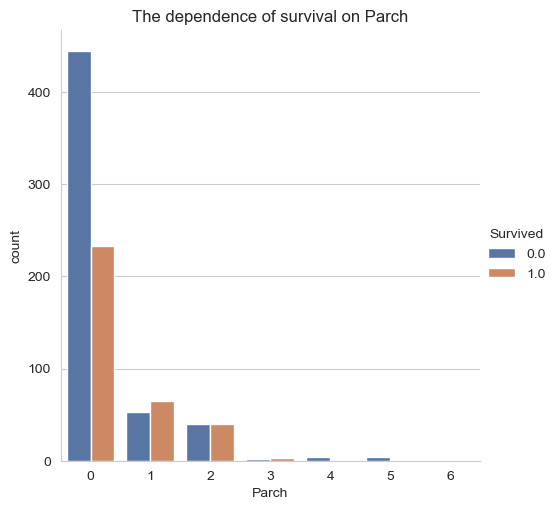

In [242]:
sns.catplot(data=train_data, x='Parch', kind='count', hue='Survived',palette='deep')
plt.title("The dependence of survival on Parch")
plt.show()

**Conclusion**: 
 - Here too the results are quite similar. Passengers with their parents on board have greater chance of survival. It however reduces as the number goes up.

 - The chances of survival is good for somebody who has 1-3 parents on the ship. Being alone also proven to be fatal and the chances for survival decreases when somebody has >4 parents on the ship.

### Fare

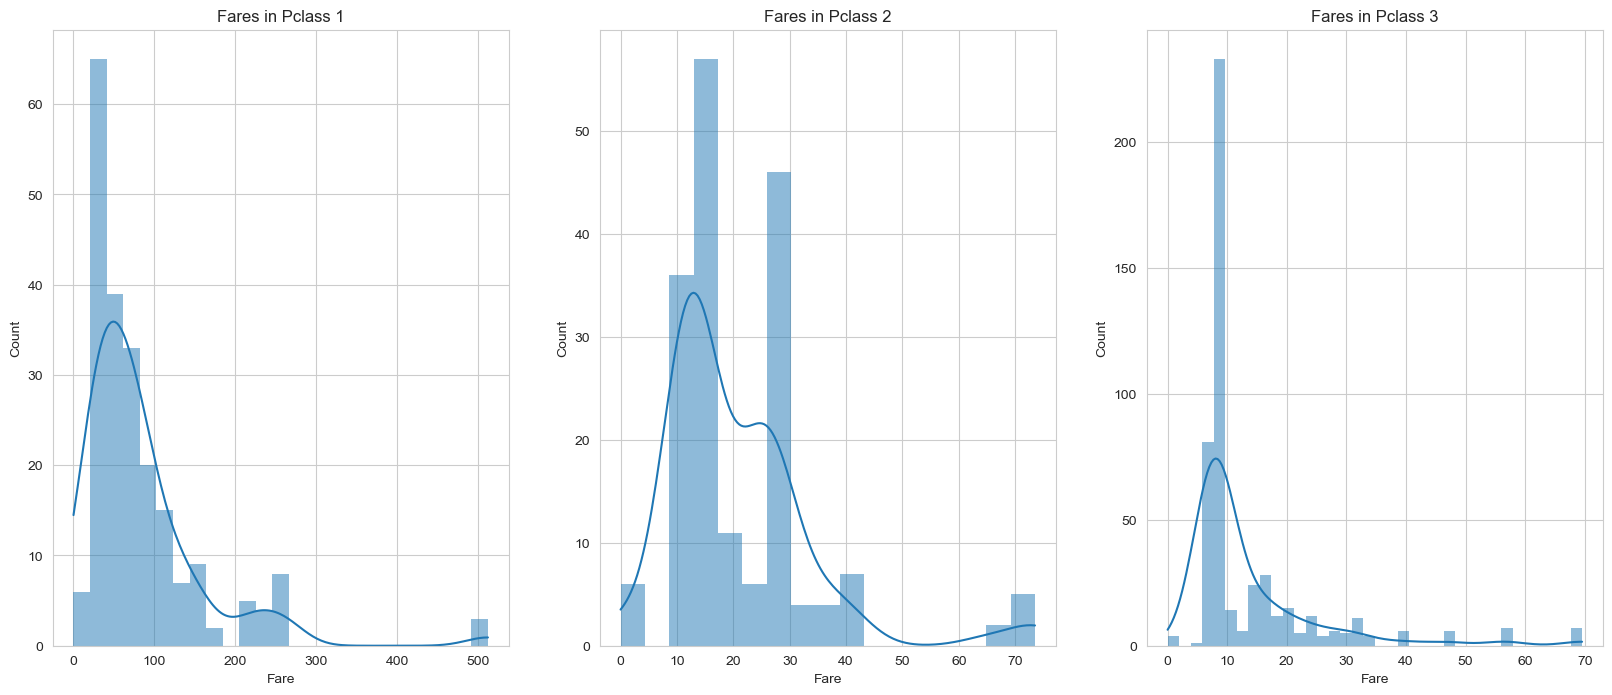

In [243]:
f,ax=plt.subplots(1,3,figsize=(20,8))

sns.histplot(train_data[train_data['Pclass']==1].Fare, ax=ax[0], kde=True, linewidth=0)
ax[0].set_title('Fares in Pclass 1')
sns.histplot(train_data[train_data['Pclass']==2].Fare,ax=ax[1], kde=True, linewidth=0)
ax[1].set_title('Fares in Pclass 2')
sns.histplot(train_data[train_data['Pclass']==3].Fare,ax=ax[2], kde=True, linewidth=0)
ax[2].set_title('Fares in Pclass 3')

plt.show()

### Correlation Between The Features

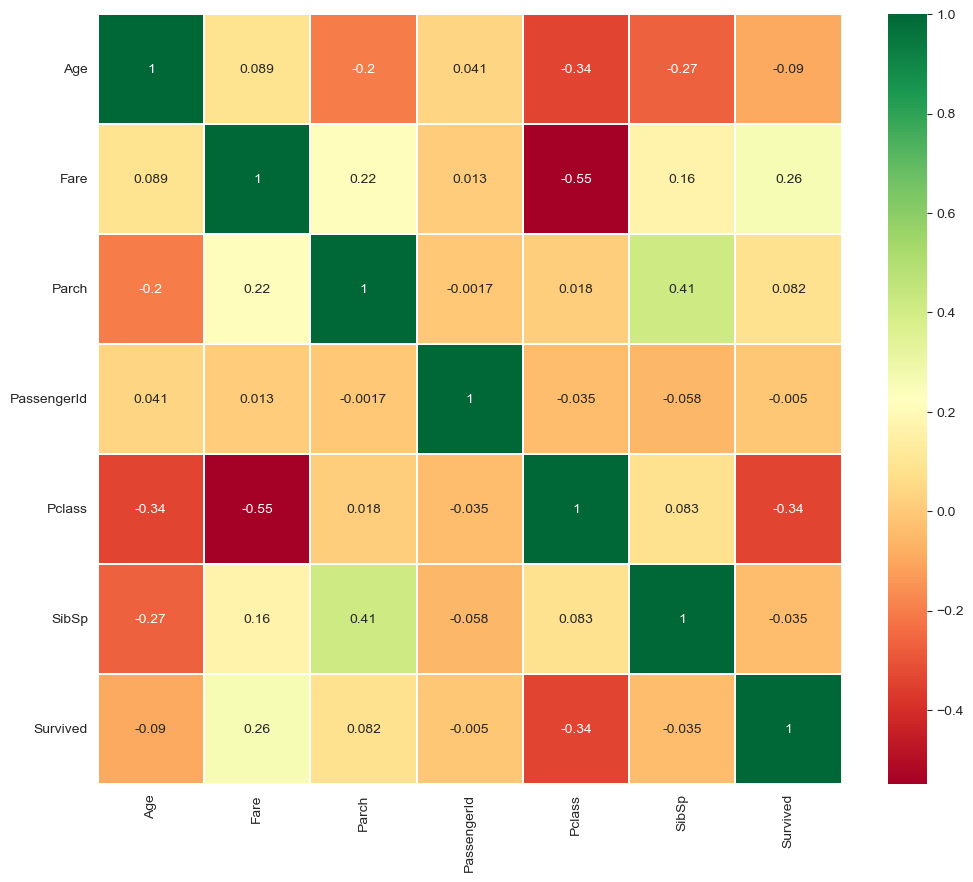

In [244]:
#data.corr()-->correlation matrix
sns.heatmap(train_data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(12,10)
plt.show()

Now from the above heatmap,we can see that the features are not much correlated. The highest correlation is between SibSp and Parch i.e 0.41. So we can carry on with all features.

## Feature Engineering

### Age group

<Axes: xlabel='Age', ylabel='Count'>

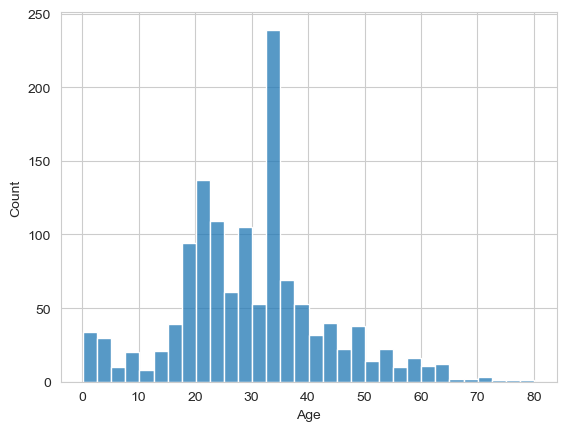

In [563]:
sns.histplot(all_data['Age'])

`Age` feature has a normal distribution with some spikes and bumps and 10 quantile based bins are used for `Age`. The first bin has the highest survival rate and 4th bin has the lowest survival rate. Those were the biggest spikes in the distribution. 

In [564]:
all_data['Age'] = pd.qcut(all_data['Age'], 10, duplicates='drop')

In [565]:
all_data.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Initial
0,"(21.0, 22.7]",S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,"(33.0, 39.0]",C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,"(22.7, 26.0]",S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,"(33.0, 39.0]",S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,"(33.0, 39.0]",S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


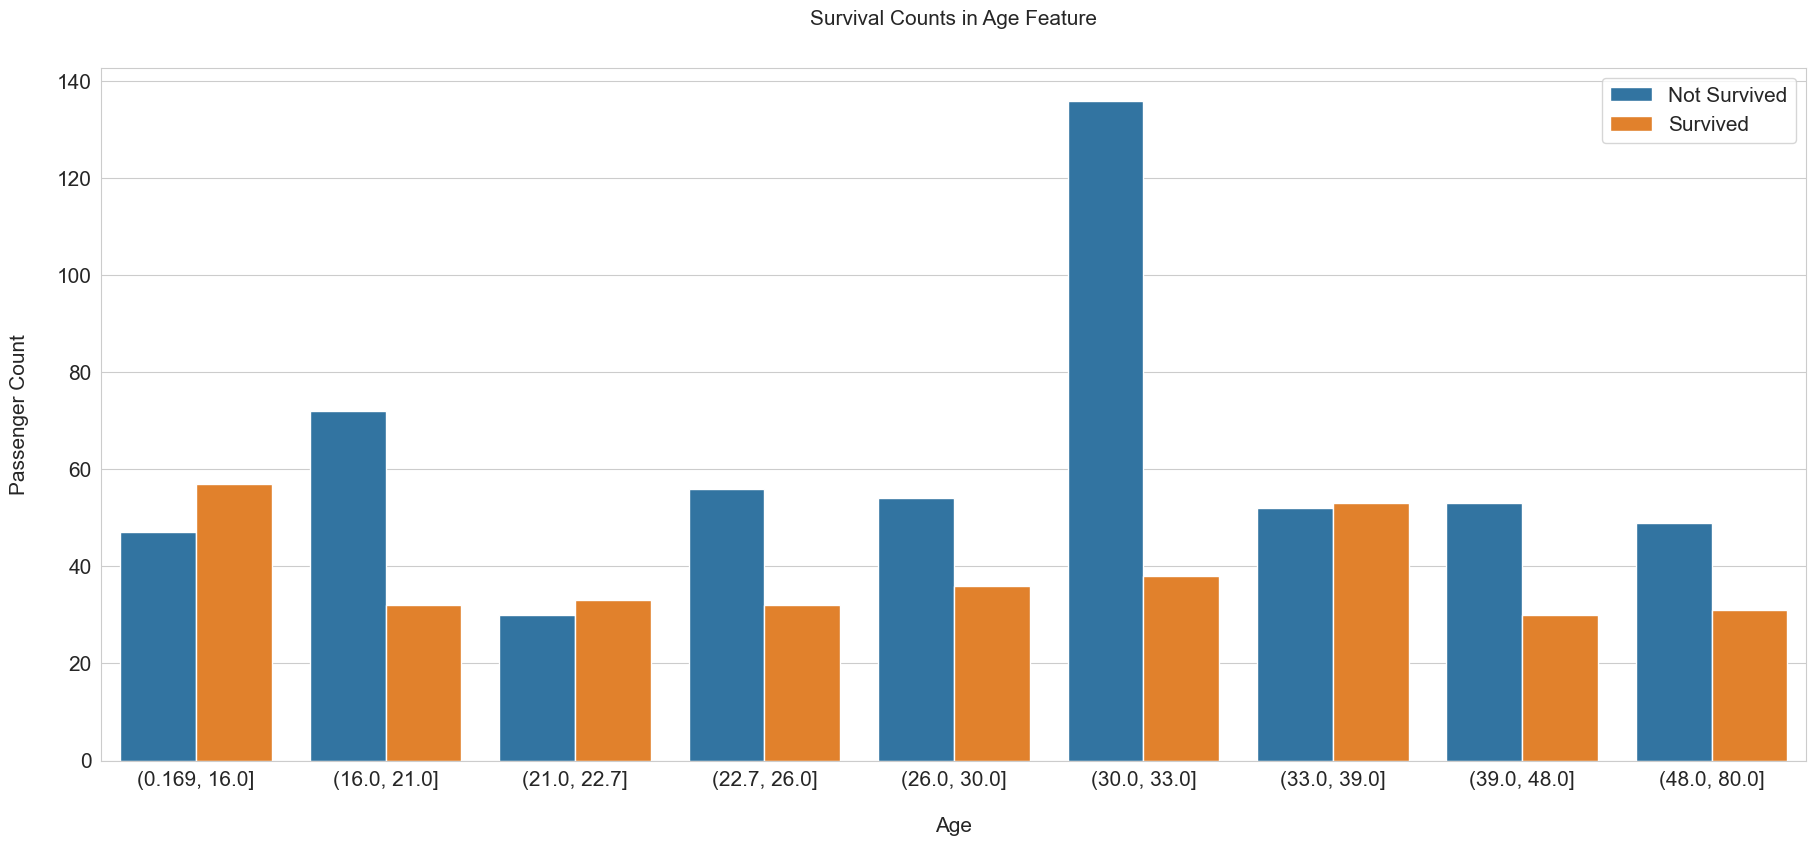

In [566]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=all_data)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

### Family_Size and Alone

**Since Perch and Subsp had the largest correlation between each other on the heat map, it may be worth summing them up.**

We create a new function called "Family_size" and "Alone" and analyze it. This gives us the combined data so we can check if the survival rate has anything to do with the size of the passengers' family. "Alone" will mean whether the passenger is alone or not.

In [567]:
all_data['Family_Size']=0
all_data['Family_Size']=all_data['Parch']+all_data['SibSp']
all_data['Alone']=0
all_data.loc[all_data.Family_Size==0,'Alone']=1

In [568]:
pd.crosstab([all_data.Family_Size], all_data.Survived).style.background_gradient(cmap='YlOrRd')

Survived,0.000000,1.000000
Family_Size,,
0,374,163
1,72,89
2,43,59
3,8,21
4,12,3
5,19,3
6,8,4
7,6,0
10,7,0


In [569]:
pd.crosstab([all_data.Alone], all_data.Survived).style.background_gradient(cmap='YlOrRd')

Survived,0.000000,1.000000
Alone,,
0,175,179
1,374,163


In [570]:
pd.crosstab(all_data.Family_Size, all_data.Pclass).style.background_gradient(cmap='YlOrRd')


Pclass,1,2,3
Family_Size,,,
0,160,158,472
1,104,52,79
2,39,45,75
3,9,20,14
4,5,1,16
5,6,1,18
6,0,0,16
7,0,0,8
10,0,0,11


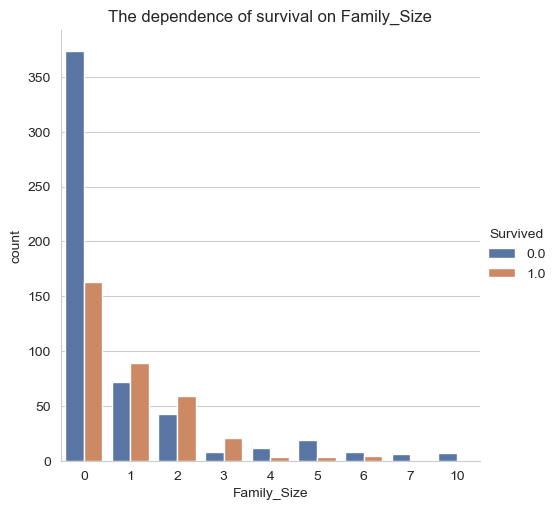

In [571]:
sns.catplot(data=all_data, x='Family_Size', kind='count', hue='Survived',palette='deep')
plt.title("The dependence of survival on Family_Size")
plt.show()

Family_Size=0 means that the passenger is alone. Clearly, if you are alone or family_size=0,then chances for survival is very low. For family size > 4,the chances decrease too. This also looks to be an important feature for the model.

### Fare


In [572]:
all_data['Fare'] = pd.qcut(all_data['Fare'], 14, duplicates='drop')

In [573]:
all_data['Fare'].value_counts()

(7.879, 8.05]       135
(19.258, 26.0]      134
(7.229, 7.75]       111
(-0.001, 7.229]      99
(27.793, 39.0]       98
(12.816, 14.454]     97
(59.4, 90.0]         96
(9.35, 12.816]       91
(14.454, 19.258]     91
(39.0, 59.4]         90
(90.0, 512.329]      90
(7.75, 7.879]        77
(26.0, 27.793]       52
(8.05, 9.35]         48
Name: Fare, dtype: int64

In [574]:
pd.crosstab([all_data.Fare], all_data.Survived).style.background_gradient(cmap='YlOrRd')

Survived,0.000000,1.000000
Fare,,
"(-0.001, 7.229]",60,10
"(7.229, 7.75]",51,19
"(7.75, 7.879]",30,14
"(7.879, 8.05]",86,15
"(8.05, 9.35]",28,5
"(9.35, 12.816]",40,27
"(12.816, 14.454]",40,22
"(14.454, 19.258]",35,29
"(19.258, 26.0]",49,36


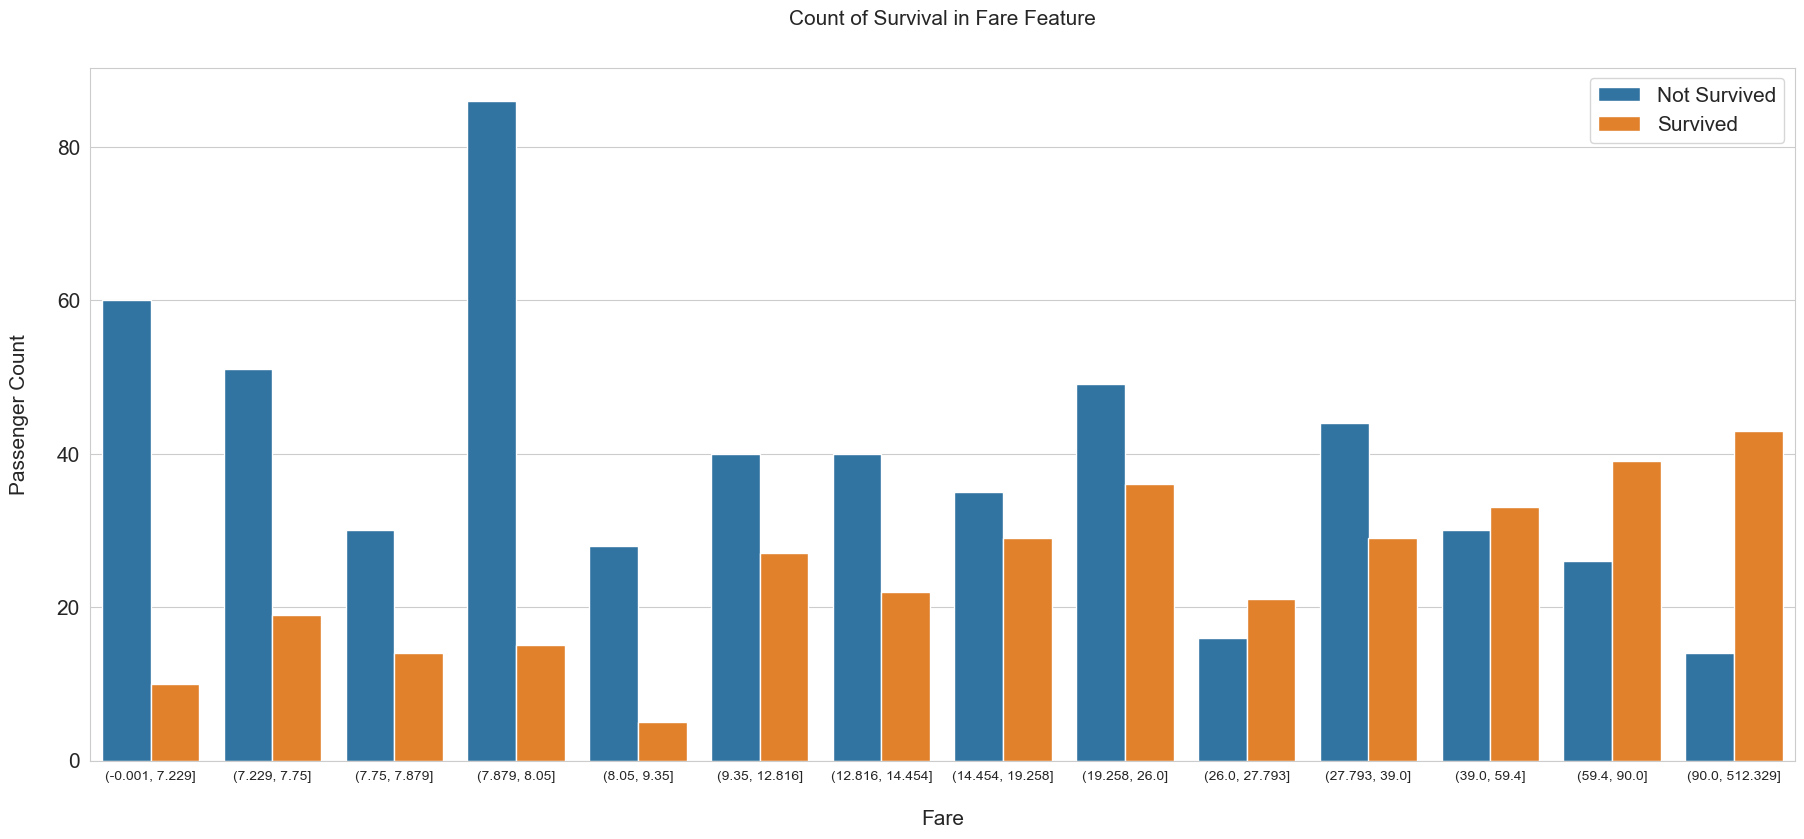

In [575]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=all_data)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

Analyzing the schedule, we can see that the higher the ticket price, the higher the passenger's survival rate.

In [576]:
all_data.head(2)

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Initial,Family_Size,Alone
0,"(21.0, 22.7]",S,"(7.229, 7.75]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,1,0
1,"(33.0, 39.0]",C,"(59.4, 90.0]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,1,0


### Removing unnecessary features

* `Ticket`feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival. 

* `PassengerId` may be dropped from training dataset as it does not contribute to survival. This feature, on the contrary, can worsen learning.

* `Name` may be dropped from training dataset as it does not contribute to survival.

* `Parch` and `SibSp` we used to form other features `Family_Size` and `Alone`

In [577]:
drop_cols = ['Name', 'PassengerId', 'Ticket', 'Parch', 'SibSp']

all_data.drop(columns=drop_cols, inplace=True)

all_data.head(3)

,Age,Embarked,Fare,Pclass,Sex,Survived,Initial,Family_Size,Alone
0,"(21.0, 22.7]",S,"(7.229, 7.75]",3,male,0.0,Mr,1,0
1,"(33.0, 39.0]",C,"(59.4, 90.0]",1,female,1.0,Mrs,1,0
2,"(22.7, 26.0]",S,"(7.879, 8.05]",3,female,1.0,Miss,0,1


In [578]:
train_data, test_data = divide_df(all_data)

In [579]:
train_data.head(3)

,Age,Embarked,Fare,Pclass,Sex,Survived,Initial,Family_Size,Alone
0,"(21.0, 22.7]",S,"(7.229, 7.75]",3,male,0.0,Mr,1,0
1,"(33.0, 39.0]",C,"(59.4, 90.0]",1,female,1.0,Mrs,1,0
2,"(22.7, 26.0]",S,"(7.879, 8.05]",3,female,1.0,Miss,0,1


In [580]:
test_data.head(3)

,Age,Embarked,Fare,Pclass,Sex,Initial,Family_Size,Alone
891,"(33.0, 39.0]",Q,"(7.75, 7.879]",3,male,Mr,0,1
892,"(39.0, 48.0]",S,"(-0.001, 7.229]",3,female,Mrs,1,0
893,"(48.0, 80.0]",Q,"(9.35, 12.816]",2,male,Mr,0,1


In [581]:
categorical_features = ['Embarked', 'Pclass', 'Sex', 'Initial', 'Alone', 'Age', 'Fare']
numeric_features = ['Family_Size']
encoded_features = []

dfs = [train_data, test_data]

for df in dfs:
    for feature in categorical_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

train_data = pd.concat([train_data, *encoded_features[:7]], axis=1)
test_data = pd.concat([test_data, *encoded_features[7:]], axis=1)

In [582]:
train_data.head(3)

,Age,Embarked,Fare,Pclass,Sex,Survived,Initial,Family_Size,Alone,Embarked_1,...,Fare_5,Fare_6,Fare_7,Fare_8,Fare_9,Fare_10,Fare_11,Fare_12,Fare_13,Fare_14
0,"(21.0, 22.7]",S,"(7.229, 7.75]",3,male,0.0,Mr,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"(33.0, 39.0]",C,"(59.4, 90.0]",1,female,1.0,Mrs,1,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,"(22.7, 26.0]",S,"(7.879, 8.05]",3,female,1.0,Miss,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Removing unnecessary features

In [583]:
all_data = pd.concat([train_data, test_data], sort=True).reset_index(drop=True)
drop_cols = ['Embarked', 'Pclass', 'Sex', 'Initial', 'Alone', 'Age', 'Fare']
drop_col = ['Survived']

all_data.drop(columns=drop_cols, inplace=True)

all_data.head(3)

,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Alone_1,...,Initial_2,Initial_3,Initial_4,Initial_5,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Survived
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


In [584]:
X_train = StandardScaler().fit_transform(train_data.drop(columns=drop_cols + drop_col))
y_train = train_data['Survived'].values
X_test = StandardScaler().fit_transform(test_data.drop(columns=drop_cols))

In [585]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 39)
y_train shape: (891,)
X_test shape: (418, 39)


## Predictive Modeling

In [586]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

83.5

In [587]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
acc_svc


87.21

In [588]:
# KNN

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

86.98

In [589]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian

76.99

In [590]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)
acc_perceptron

81.48

In [591]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
acc_linear_svc

/Users/mac/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


83.5

In [592]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
acc_sgd

80.02

In [593]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

93.04

In [594]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

93.04

In [595]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,93.04
8,Decision Tree,93.04
0,Support Vector Machines,87.21
1,KNN,86.98
2,Logistic Regression,83.50
7,Linear SVC,83.50
5,Perceptron,81.48
6,Stochastic Gradient Decent,80.02
4,Naive Bayes,76.99
